# Imports

In [1]:
import torch.nn as nn
import torch

from datetime import datetime
import models.SANet as SANet
import utils.data as data
from utils.eval import compute_ssim, plot_results
import models.AdaIN as adain

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and Dataloaders

In [2]:
import torchvision.transforms as transforms

val_tf = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

_, content_validloader, _, _, style_validloader, _ = data.get_dataloaders(bs=64, valid_tf=val_tf)


# pre trained

In [3]:
decoder = adain.decoder
vgg = adain.vgg

decoder.load_state_dict(torch.load("models/output/decoder.pth"))
vgg.load_state_dict(torch.load("models/output/vgg_normalised.pth"))
vgg = nn.Sequential(*list(vgg.children())[:31])

vgg.to(device)
decoder.to(device)

Sequential(
  (0): ReflectionPad2d((1, 1, 1, 1))
  (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (2): ReLU()
  (3): Upsample(scale_factor=2.0, mode='nearest')
  (4): ReflectionPad2d((1, 1, 1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): ReflectionPad2d((1, 1, 1, 1))
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): ReflectionPad2d((1, 1, 1, 1))
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (12): ReLU()
  (13): ReflectionPad2d((1, 1, 1, 1))
  (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (15): ReLU()
  (16): Upsample(scale_factor=2.0, mode='nearest')
  (17): ReflectionPad2d((1, 1, 1, 1))
  (18): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (19): ReLU()
  (20): ReflectionPad2d((1, 1, 1, 1))
  (21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (22): ReLU()
  (23): Upsample(scale_factor=2.0, mode='nearest')
  (24): ReflectionPad2d((1, 1, 1, 1))
  (25): Conv2d(64

In [4]:
def adain_run(vgg, decoder, content_loader, style_loader):
    decoder.eval()
    vgg.eval()
    total_samples = 0
    running_content_loss, running_style_loss = 0.0, 0.0
    with torch.no_grad():
        for content, style in zip(content_loader, style_loader):
            content_images = content.to(device)
            style_images, style_labels = style
            style_images, style_labels = style_images.to(device), style_labels.to(device)
            
            stylised_images, content_loss, style_loss = adain.style_transfer(vgg, decoder, content_images, style_images, device=device)
            
            running_style_loss += style_loss.item()
            running_content_loss += content_loss.item()
            
            if total_samples == 0:
                plot_results(content_images, style_images, style_labels, stylised_images)
            total_samples += style_labels.size(0)

    avg_content_loss = running_content_loss / total_samples
    avg_style_loss = running_style_loss / total_samples
    return avg_content_loss, avg_style_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


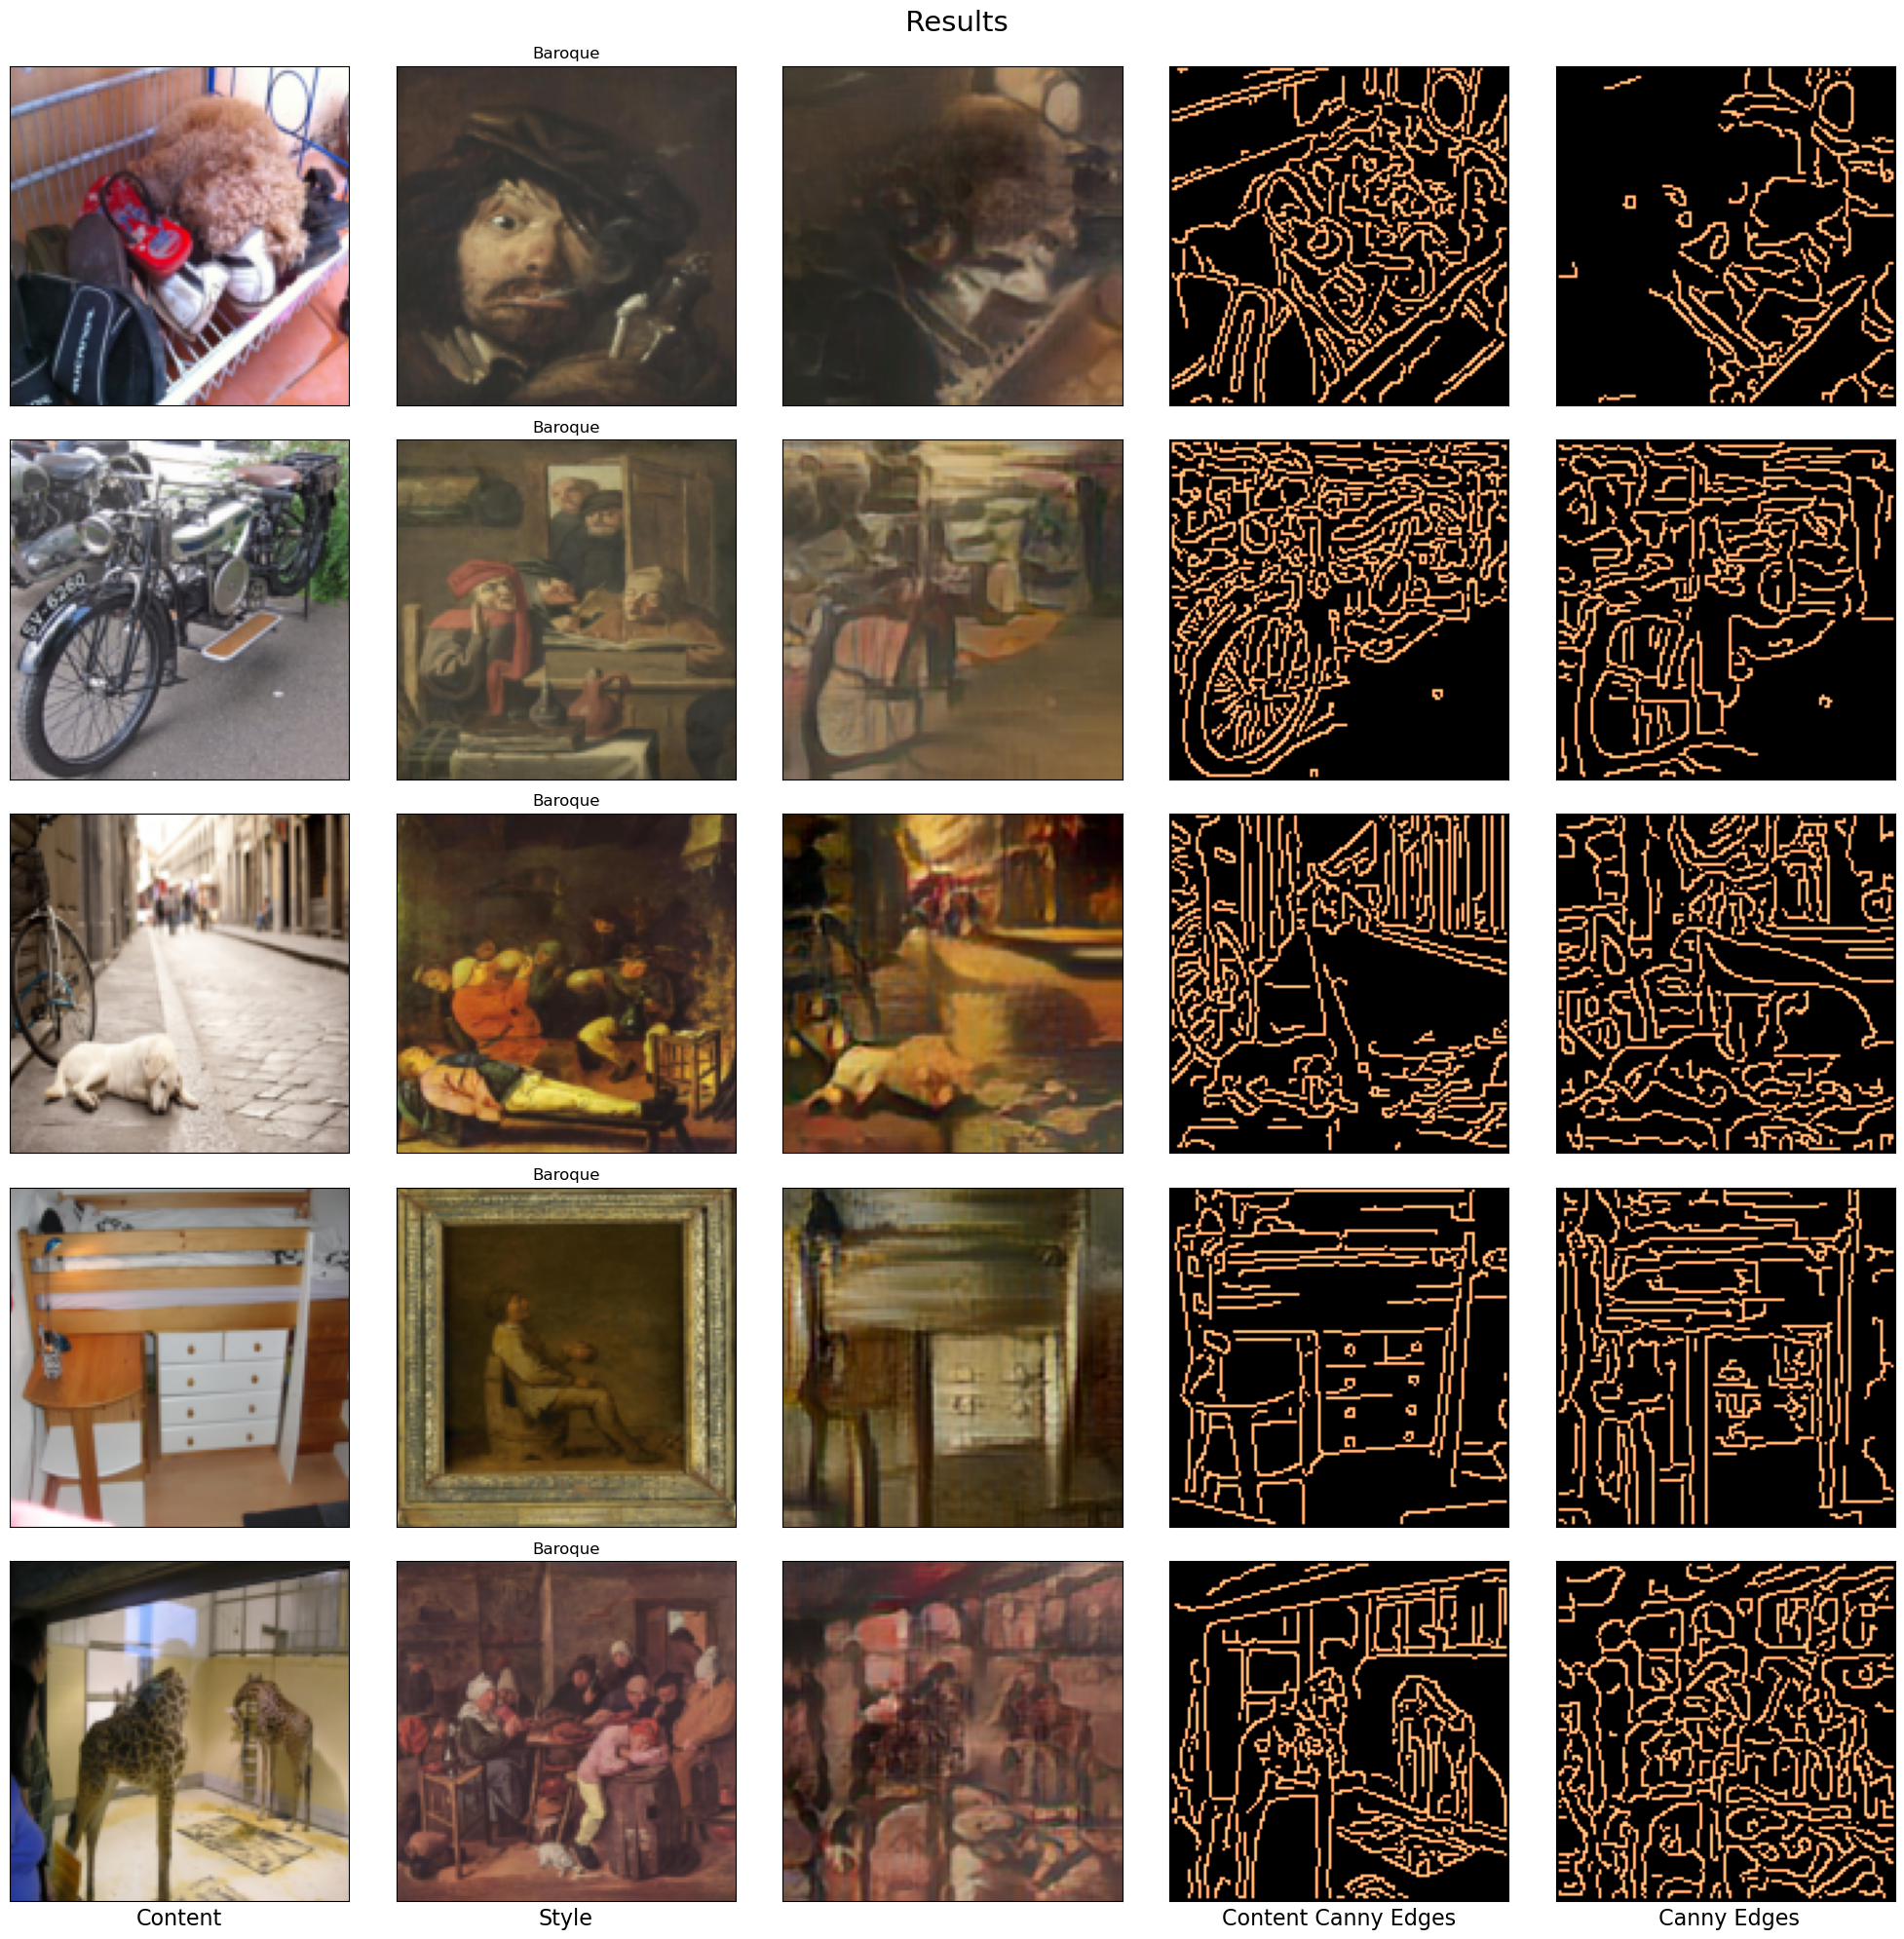

(0.001399722679747337, 4.092285565602842e-05)

In [5]:
adain_run(vgg, decoder, content_validloader, style_validloader)